In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [5]:
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    precision_score, 
    recall_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

In [6]:
df = pd.read_csv("../../our_analyses/dataset_prepared.csv")

In [7]:
from sklearn.preprocessing import LabelEncoder

df=df.drop(['name', 'artists', 'album_name'], axis=1)

genre_groups = {
    'idm': 0, 'iranian': 0, 'study': 0,  # Electronic/Dance
    'black-metal': 1, 'breakbeat': 1, 'techno': 1,  # Metal/Rock
    'brazil': 2, 'forro': 2, 'happy': 2, 'spanish': 2, 'j-idol': 2,  # Country/Folk/Pop
    'afrobeat': 3, 'chicago-house': 3, 'industrial': 3, 'j-dance': 3,  # World/Commercial Pop
    'bluegrass': 4, 'disney': 4, 'indian': 4, 'mandopop': 4, 'sleep': 4  # Other
}


genre_labels = ['Metal and Related', 'Metal/Rock', 'Country/Folk', 'Pop/Commercial', 'World', 'Ambient/New Age', 'Other', 'Indian']


# Mappatura dei generi del dataframe ai gruppi di generi
df['genre_group'] = df['genre'].map(genre_groups).astype(int)

# Stampa del mapping dei generi ai numeri corrispondenti
print(df['genre_group'].unique())

le = LabelEncoder()
df['explicit'] = le.fit_transform(df['explicit'])

[3 1 4 2 0]


In [8]:
# Definizione di y come l'array delle etichette dei generi
y = np.array(df['genre_group'])

# Rimozione delle colonne 'genre_group' e 'genre' per ottenere le feature
X = df.drop(['genre_group', 'genre'], axis=1)


In [9]:
from sklearn.model_selection import train_test_split

random_state = 0

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=random_state
)

print(np.unique(y, return_counts=True)[1] / len(y))
print(np.unique(y_train, return_counts=True)[1] / len(y_train))
print(np.unique(y_test, return_counts=True)[1] / len(y_test), ("\n"))
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

[0.15 0.15 0.25 0.2  0.25]
[0.15 0.15 0.25 0.2  0.25]
[0.15 0.15 0.25 0.2  0.25] 

(10500, 16) (4500, 16) (10500,) (4500,)


In [10]:
from sklearn.preprocessing import StandardScaler

norm = StandardScaler()
norm.fit(X_train)

X_train_norm = norm.transform(X_train)
X_test_norm = norm.transform(X_test)

In [24]:
from sklearn.naive_bayes import GaussianNB, CategoricalNB

clf = GaussianNB()
clf.fit(X_train_norm, y_train)

GaussianNB()

In [12]:
y_test_pred = clf.predict(X_test_norm)
y_test_pred

array([3, 2, 3, ..., 2, 0, 1])

In [13]:
print("Accuracy:", accuracy_score(y_test, y_test_pred))

Accuracy: 0.5386666666666666


In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
import numpy as np

# Definizione di un range più ampio per var_smoothing
var_smoothing_range = np.logspace(-50, -10, 2000)

param_grid_nb = {
    'var_smoothing': var_smoothing_range
}

# Creazione del modello GridSearchCV
grid_search = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, cv=5, n_jobs=-1, scoring='accuracy')

# Addestramento del modello
grid_search.fit(X_train_norm, y_train)

# Stampa dei migliori parametri
print("Migliori parametri:", grid_search.best_params_)

# Utilizza il miglior modello per le previsioni
y_test_pred = grid_search.predict(X_test_norm)

# Valuta il modello migliorato
print(accuracy_score(y_test, y_test_pred))


Migliori parametri: {'var_smoothing': 1e-50}
0.5386666666666666


In [14]:
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix

# Assumiamo che 'y_test' e 'y_test_pred' siano già definiti e contengano le etichette vere e predette dal tuo modello

# Genera la matrice di confusione
cf = confusion_matrix(y_test, y_test_pred)

# Definisci le etichette per i generi in base ai raggruppamenti definiti
genre_labels = [' Electronic/Dance', 'Metal/Rock', 'Country/Folk/Pop', 'World/Commercial Pop', 'Other']

# Crea la heatmap usando plotly
fig = ff.create_annotated_heatmap(z=cf, x=genre_labels, y=genre_labels,
                                  annotation_text=cf.astype(str), colorscale='Greens')

# Aggiorna il layout
fig.update_layout(title_text='Confusion Matrix', title_x=0.02,
                  xaxis=dict(title='Predicted Labels', tickangle=45),
                  yaxis=dict(title='True Labels', tickmode='array', tickvals=list(range(len(genre_labels))), ticktext=genre_labels),
                  yaxis_autorange='reversed')  # Reverse the y-axis to have the first class at the top

# Mostra il grafico
fig.show()



In [16]:
import plotly.graph_objects as go
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score

# Binarizza le etichette in un formato one-vs-rest e calcola i punteggi di probabilità per le classi
Y = label_binarize(y_test, classes=np.unique(y_test))
y_scores = clf.predict_proba(X_test_norm)

# Inizializza dizionari per precision e recall
precision = dict()
recall = dict()
average_precision = dict()

# Calcola precision e recall per ogni classe
for i in range(len(np.unique(y_test))):
    precision[i], recall[i], _ = precision_recall_curve(Y[:, i], y_scores[:, i])
    average_precision[i] = average_precision_score(Y[:, i], y_scores[:, i])

# Crea un grafico Plotly
fig = go.Figure()

# Aggiunge una linea per ogni classe
for i, genre in enumerate(np.unique(y_test)):
    fig.add_trace(go.Scatter(x=recall[i], y=precision[i], mode='lines', name=f'Class {i} (AP={average_precision[i]:0.2f})'))

# Aggiorna il layout
fig.update_layout(
    title="Precision-Recall curve",
    xaxis_title="Recall",
     width=1000,  # Larghezza del plot
    height=800,  
    yaxis_title="Precision",
    legend_title="Classes"
)

# Mostra il grafico
fig.show()


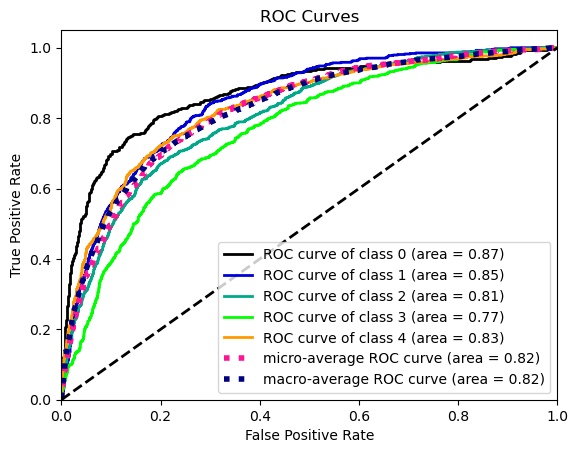

In [27]:
y_test_pred_proba = clf.predict_proba(X_test_norm) 
y_test_pred_proba[0:10]

plot_roc(y_test, y_test_pred_proba)
plt.show()

In [28]:
from sklearn.metrics import roc_curve, auc
import plotly.graph_objects as go

# Calcola ROC curve e AUC per ogni classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(y_test))):
    fpr[i], tpr[i], _ = roc_curve(Y[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Crea un grafico Plotly
fig = go.Figure()

# Aggiunge una linea per ogni classe
for i, genre in enumerate(np.unique(y_test)):
    fig.add_trace(go.Scatter(x=fpr[i], y=tpr[i], mode='lines', name=f'Class {i} (AUC={roc_auc[i]:0.2f})'))

# Aggiunge la linea diagonale per il random guessing
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random Guessing', line=dict(dash='dash')))

# Aggiorna il layout
fig.update_layout(
    title="ROC curve per classe",
    xaxis_title="False Positive Rate",
     width=1000,  # Larghezza del plot
    height=800,  
    yaxis_title="True Positive Rate",
    legend_title="Classes"
)

# Mostra il grafico
fig.show()


In [29]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.72      0.43      0.54       675
           1       0.50      0.55      0.52       675
           2       0.46      0.73      0.57      1125
           3       0.51      0.32      0.40       900
           4       0.64      0.57      0.61      1125

    accuracy                           0.54      4500
   macro avg       0.57      0.52      0.53      4500
weighted avg       0.56      0.54      0.53      4500

